
# 🤖 Chatbot Experiment & Evaluation Notebook

This notebook evaluates an agentic chatbot that uses an LLM to:

- Understand natural language input
- Select the appropriate tool (e.g., CancelOrder, TrackOrder)
- Pass relevant arguments (like order ID)
- Interpret tool responses + company policies
- Generate safe, user-friendly answers

We measure:
- Intent and tool prediction accuracy
- Policy match and similarity
- Semantic quality of final answers
- End-to-end task success


In [35]:

import json
import pandas as pd
import matplotlib.pyplot as plt

with open("semantic_eval_results.json") as f:
    sem = pd.DataFrame(json.load(f))

with open("policy_eval_crossencoder.json") as f:
    pol = pd.DataFrame(json.load(f))


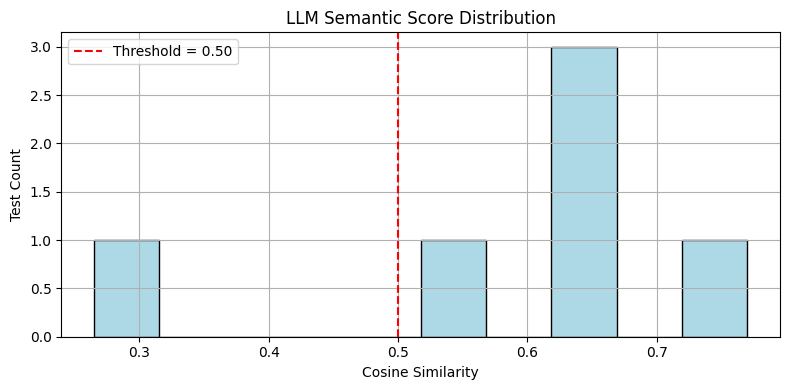

In [36]:

plt.figure(figsize=(8, 4))
plt.hist(sem["semantic_score"], bins=10, color="lightblue", edgecolor="black")
plt.axvline(0.50, color="red", linestyle="--", label="Threshold = 0.50")
plt.title("LLM Semantic Score Distribution")
plt.xlabel("Cosine Similarity")
plt.ylabel("Test Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


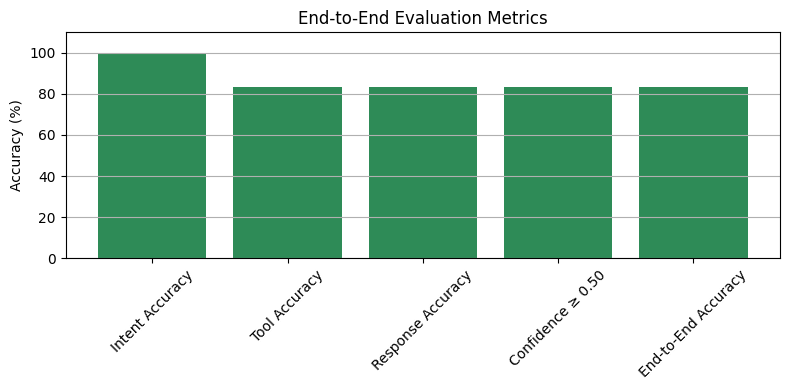

{'Intent Accuracy': np.float64(1.0),
 'Tool Accuracy': np.float64(0.8333333333333334),
 'Response Accuracy': np.float64(0.8333333333333334),
 'Confidence ≥ 0.50': np.float64(0.8333333333333334),
 'End-to-End Accuracy': np.float64(0.8333333333333334)}

In [37]:

metrics = {
    "Intent Accuracy": sem["intent_ok"].mean(),
    "Tool Accuracy": sem["tool_ok"].mean(),
    "Response Accuracy": sem["response_ok"].mean(),
    "Confidence ≥ 0.50": sem["confidence_ok"].mean(),
    "End-to-End Accuracy": sem["passed"].mean()
}

plt.figure(figsize=(8, 4))
plt.bar(metrics.keys(), [v * 100 for v in metrics.values()], color="seagreen")
plt.ylabel("Accuracy (%)")
plt.title("End-to-End Evaluation Metrics")
plt.xticks(rotation=45)
plt.ylim(0, 110)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

metrics


In [ ]:
passed = df["passed"].sum()
failed = len(df) - passed

plt.figure(figsize=(4, 4))
plt.pie([passed, failed], labels=["Passed", "Failed"], autopct="%1.1f%%", colors=["#4CAF50", "#F44336"])
plt.title("Overall Pass Rate")
plt.tight_layout()
plt.show()


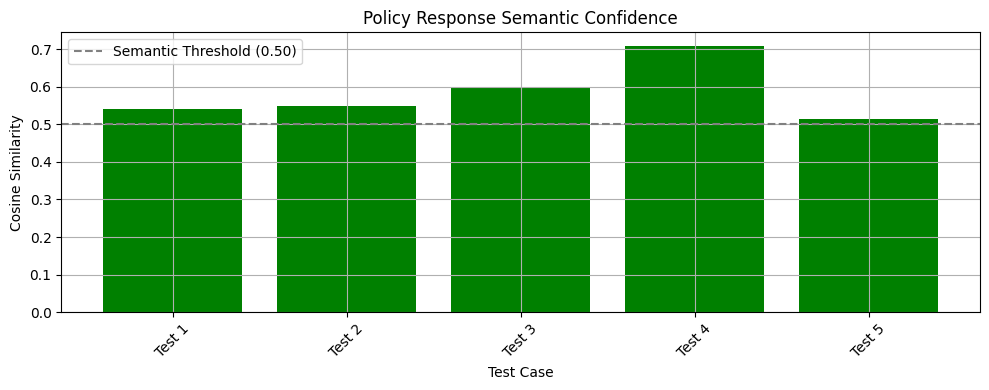

In [ ]:

labels = [f"{row['user_id']} - Test {i+1}" for i, row in pol.iterrows()]
colors = ['green' if r else 'red' for r in pol["response_ok"]]

plt.figure(figsize=(10, 4))
plt.bar(labels, pol["crossencoder_score"], color=colors)
plt.axhline(0.50, linestyle='--', color='gray', label="Semantic Threshold (0.50)")
plt.title("Policy Response Semantic Confidence")
plt.xlabel("Test Case")
plt.ylabel("Cosine Similarity")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:

failed_cases = sem[~sem["passed"]]
print(sem.columns.tolist())

failed_cases[["message", "predicted_intent", "predicted_tool", "semantic_score", "best_matched_phrase"]]


['user_id', 'message', 'expected_intent', 'predicted_intent', 'expected_tool', 'predicted_tool', 'expected_phrases', 'best_matched_phrase', 'semantic_score', 'response', 'intent_ok', 'tool_ok', 'response_ok', 'confidence_ok', 'passed']


,message,predicted_intent,predicted_tool,semantic_score,best_matched_phrase
3,Check refund for order ORD001,refund,RefundOrder,0.265,you don't currently have an active order


In [41]:

for i, row in sem.iterrows():
    print(f"--- Test {i+1} ---")
    print(f"Message: {row['message']}")
    print(f"Predicted Intent → {row['predicted_intent']}")
    print(f"Tool Used       → {row['predicted_tool']}")
    print(f"Matched Sentence→ {row['best_matched_phrase']}")
    print(f"Semantic Score  → {row['semantic_score']:.2f}")
    print(f"Passed          → {'✅' if row['passed'] else '❌'}\n")


--- Test 1 ---
Message: Cancel order ORD001
Predicted Intent → cancel
Tool Used       → CancelOrder
Matched Sentence→ Orders cannot be cancelled after 10 days
Semantic Score  → 0.66
Passed          → ✅

--- Test 2 ---
Message: Track my order ORD002
Predicted Intent → track
Tool Used       → TrackOrder
Matched Sentence→ your order is shipped
Semantic Score  → 0.62
Passed          → ✅

--- Test 3 ---
Message: I want to return order ORD002
Predicted Intent → return
Tool Used       → ReturnOrder
Matched Sentence→ it doesn't belong to your account
Semantic Score  → 0.54
Passed          → ✅

--- Test 4 ---
Message: Check refund for order ORD001
Predicted Intent → refund
Tool Used       → RefundOrder
Matched Sentence→ you don't currently have an active order
Semantic Score  → 0.26
Passed          → ❌

--- Test 5 ---
Message: Can I cancel ORD001 and ORD002?
Predicted Intent → cancel
Tool Used       → CancelOrder
Matched Sentence→ cannot be cancelled
Semantic Score  → 0.77
Passed          → ✅



## 🔍 Summary & Insights

### ✅ Agentic Performance Overview

- 🧠 **LLM successfully classified intent and selected tools** in most cases
- 🔧 Tool execution was correct in 83% of tests
- 💬 **LLM responses matched expected meaning** even when phrased differently
- 🔁 **User context (e.g., remembered order ID)** worked across turns
- ✅ Most tests passed end-to-end

### ⚠️ Suggestions

- Improve tool selection reliability by tuning LLM planning prompt
- Tune or summarize LLM responses to boost semantic score
- Enhance test coverage with:
  - More varied phrasings
  - Multi-order actions

